# <center> Week 2 - DNA Sequencing Algorithms </center>

### <center> My implementation of various algorithms explained in the lecture </center>

In [1]:
import bm_preproc
from bm_preproc import BoyerMoore #import from class lecture on BoyerMoore
import functions
from functions import readf
import matplotlib.pyplot as plt
import bisect
import numpy as np
from scipy.stats import norm

In [2]:
alphabet='ATCG' #dictionary of letters for all BoyerMoore's object

### Processing of pattern 'p' and not processing text 't' (Online processing)

In [3]:
def boyer_moore(pattern,text,bm_obj):
    occurances=[]
    for t in range(len(text)-len(pattern)+1):
        mismatch=False
        for p in reversed(range(len(pattern))):
            if text[t+p]!=pattern[p]:
                shift_bad_char=bm_obj.bad_character_rule(p, pattern[p])
                shift_good_suffix=bm_obj.good_suffix_rule(p)
                shift=max(shift_bad_char,shift_good_suffix,1)
                mismatch=True
                break
        if not mismatch:
            occurances.append(t)
            shift=max(1,bm_obj.match_skip())
        t+=shift
    return list(set(occurances))

In [4]:
t='GCTACGATCTAGAATCTA'
p='TCTA'

bm=BoyerMoore(p,alphabet)

In [5]:
print(boyer_moore(p,t,bm))

[14, 7]


### Processing of processing text 't' (Offline processing)

#### Indexing

In [6]:
#Understanding the bisect function. Basically, bisect_left tells us the left most position in text where we can insert a specific string 
import bisect
def find_insertion(text, pattern):
    check=bisect.bisect_left(sorted(text),pattern) #Sorted is required to ensure that the correct position is chosen. Analogy to a dictionary: if a dictionary wasn't sorted, we wouldn't be able to find the word
    return check,sorted(text)
#We use pattern[0] because later, we need to use this to find the position in an index which is an array of (kmer,position of that kmer in text)

In [7]:
print(find_insertion('abcefweejdfabcwefgjahabcegjej','lmn')) #Use -1 only for finding within a string. When we use an index, this will be included in the index

(27, ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e', 'e', 'f', 'f', 'f', 'g', 'g', 'h', 'j', 'j', 'j', 'j', 'w', 'w'])


Hence, find_insertion() finds the insertion point at index / offset 4 which is between the last instance of 'a' and first instance of 'b'

### K-mer lookup in the text index

<ol><li> We create an index of all combination of k substrings (integer k < len(pattern)) of the text and create a lookup table of the same (containing the k-mer and its index/ offset. ----> <b>create_index() </b></li>
<li> We then create similar k-mers of the pattern and look up the index of the pattern k-mer to see if it exists. ----> <b>find_all_indexes()</b></li>
<li> Once we confirm that the kmer exists, we use the same to VERIFY if the rest of the pattern is also present at the offset ---> <b>verify_pattern()</b></li></ol>

In [8]:
def create_index(text, kmer): #Create the index of all kmers from text 't'
    index={}
    for i in range(len(text)-kmer+1):
        if text[i:i+kmer] in index:
            index[text[i:i+kmer]]+=[i]
        else:
            index[text[i:i+kmer]]=[i]
    return index

find_insertion_index() only provides us with the first insertion point, if any, for the pattern <b> k-mer </b>. We still need to perform verification for the rest of the pattern

In [9]:
def find_all_indexes(index, pattern,kmer): #does not use bisect
    sample=pattern[:kmer]
    if sample in index.keys():
        return index[sample]

In [10]:
def verify_pattern(index, text, pattern,kmer):
    hits=find_all_indexes(index, pattern, kmer)
    print('hits:',hits)
    matches=True
    occurances=[]
    for h in hits:
        for i in range(len(pattern)-kmer+1):
            if text[h+i]!=pattern[i]:
                matches=False
                break
        if matches:
            occurances.append(h)
    return occurances

In [11]:
text_sample='GCTACGATCTAGAATCTA'
pattern_sample='TCTA'
kmer=2
index=create_index(text_sample, kmer)
print(verify_pattern(index,text_sample,pattern_sample,kmer))

hits: [7, 14]
[7, 14]


### Approximate Matching

### Sub-sequence Matching

Subsequence matching would pretty much follow the K-mer lookup process except we need an additional function that creates the logic for the substrings

In [12]:
def create_subsequence(text, leng,interval):#creates subsequences of length "leng" whose initial chars are "interval" values apart
    subsequence=[]
    for i in range(len(text)):
        str1=''
        for r in range(i,len(text),interval):
            str1+=text[r]
            if len(str1)>=leng:
                break
        if len(str1)==leng:
            subsequence.append((str1,i))
        i+=1
    return subsequence

In [13]:
print(create_subsequence('ATATATATATAT',3,2))

[('AAA', 0), ('TTT', 1), ('AAA', 2), ('TTT', 3), ('AAA', 4), ('TTT', 5), ('AAA', 6), ('TTT', 7)]


In [14]:
def create_subsequence_index(text, leng, interval):
    index={}
    subsequences=create_subsequence(text, leng, interval)
    subsequence_key,subsequence_value=[i for i in zip(*subsequences)]
    for i in range(len(subsequence_key)):
        if subsequence_key[i] in index:
            index[subsequence_key[i]].append(subsequence_value[i])
        else:
            index[subsequence_key[i]]=[subsequence_value[i]]
    return index,subsequences        

In [15]:
def find_subsequence_index(index, pattern, leng, interval):
    occurances=[]
    subsequences_pattern=create_subsequence(pattern, leng, interval)
    subsequence_key_pattern,_=[i for i in zip(*subsequences_pattern)]
    print('pattern_sub',subsequence_key_pattern)
    count=0
    for sub in subsequence_key_pattern:
        if sub in index[0]:
            occurances.append(index[0][sub])
        count+=1
    return occurances,len(subsequence_key_pattern),count

In [16]:
def verify_subsequence_pattern(index, text,pattern, leng, interval,mismatch_threshold=1):
    hits, pattern_key_length, total_key_matches=find_subsequence_index(index, pattern, leng, interval)
    print('hits',hits)
    matches=True
    occurances=[]
    index_hits=0
    for h in hits:
        h=list(h)
        for i in h:
            index_hits+=1
            mismatch_count=0
            for j in range(interval+1):
                if text[i+j]!=pattern[j]:
                    mismatch_count+=1
                    if mismatch_count>mismatch_threshold:
                        matches=False
                        break
        if matches:
            occurances.append(h)
    return np.squeeze(occurances).tolist(),index_hits

In [17]:
text1=next(iter(readf('chr1.GRCh38.excerpt.fasta').values()))

In [18]:
indexq=create_subsequence_index(text1, 8, 3)

In [19]:
verify_subsequence_pattern(indexq, text1,'GGCGCGGTGGCTCACGCCTGTAAT',8, 3,2)

pattern_sub ('GGGGCGTA', 'GCTCACGA', 'CGGTCCTT')
hits [[56922, 67486, 83863, 84641, 84775, 124024, 147558, 191452, 199607, 262042, 262174, 273669, 322735, 364263, 421354, 454332, 465647, 471966, 472634, 489019, 558456, 579737, 596898, 635931, 651523, 657496, 658702, 681737, 707151, 712449, 717706, 719418, 719557, 746620, 747359], [22398, 32640, 56923, 84642, 100012, 108111, 137575, 147559, 151719, 160163, 160730, 262043, 273670, 364264, 366819, 421222, 429300, 465648, 479031, 551135, 551828, 635932, 657497, 681738, 717707, 724928, 745641, 783347, 794643], [23005, 56924, 141048, 160731, 191454, 262044, 349191, 364265, 429301, 657498, 704733, 717708, 724929, 747361, 766421]]


([56922,
  67486,
  83863,
  84641,
  84775,
  124024,
  147558,
  191452,
  199607,
  262042,
  262174,
  273669,
  322735,
  364263,
  421354,
  454332,
  465647,
  471966,
  472634,
  489019,
  558456,
  579737,
  596898,
  635931,
  651523,
  657496,
  658702,
  681737,
  707151,
  712449,
  717706,
  719418,
  719557,
  746620,
  747359],
 79)

##### Sample Check 1

In [20]:
text_eg='to-morrow and to-morrow and to-morrow creeps in this petty pace'
index_eg=create_subsequence_index(text_eg, 8, 3)

In [21]:
occurances=verify_subsequence_pattern(index_eg, text_eg,'to-morrow and to-morrow ',8, 3,2)
occurances

pattern_sub ('tmr dooo', 'oooa -rw', '-rwntmr ')
hits [[0, 14], [1, 15], [2, 16]]


([0, 14], 6)

##### Sample check 2

In [22]:
t = open('pg1110.txt').read()
p = 'English measure backward'
index_sp=create_subsequence_index(t, 8, 3)

In [23]:
occurances=verify_subsequence_pattern(index_sp, t,p,8, 3,2)
occurances

pattern_sub ('Elheu ca', 'ni arbkr', 'gsmseawd')
hits [[132576], [132577], [132578]]


(132576, 3)

### Pigeonhole

Basically, we need to divide the pattern into (n+1) non-overlapping but mutually exclusive lists where n is the maximum number of mismatches allowed. Then, we check every one of these lists to the text and check if atleast one of these lists are an exact match (probably using Boyle Moore)

##### Use BoyerMoore naive lookup

In [24]:
def get_BM_model(p,alphabet='ATGC'):
    return BoyerMoore(p,alphabet)

In [25]:
def get_patterns(p, mismatches):
    batch_number=mismatches+1
    batch_size=int(round(len(p)//batch_number))
    print(batch_size)
    batches=[]
    for i in range(0,len(p),batch_size):
        batches.append(p[i:i+batch_size])
    return batches
                       

In [26]:
def compare_batches_bm(batches, text, pattern, mismatch_th=2):
    complete_matches=set()
    batch_length=len(batches[0])
    for i,batch in enumerate(batches):
        bm_obj=BoyerMoore(batch,alphabet='ATCG')
        occurance_batch=boyer_moore(batch,text,bm_obj)
        for m in occurance_batch:
            if m<i*batch_length or m-(i*batch_length)+len(pattern)>len(text):                    
                continue
            mismatches=0
            for j in range(0,i*batch_length):
                if text[m-i*batch_length+j]!=pattern[j]:
                    mismatches+=1
                    if mismatches>mismatch_th:
                        break
            for j in range(min((i+1)*batch_length,len(p)),len(p)):
                if text[m-i*batch_length+j]!=pattern[j]:
                    mismatches+=1
                    if mismatches>mismatch_th:
                        break
            if mismatches<=mismatch_th:
                complete_matches.append(m-i*batch_length)
    return list(complete_matches)      

In [27]:
t='CACTTAATTTG'
p='AACTTG'
pattern_batches=get_patterns(p,mismatches=2)
print(pattern_batches)
final=compare_batches_bm(pattern_batches, t, p, mismatch_th=2)
print(len(final))
print(len(set(final)))

2
['AA', 'CT', 'TG']
batch AA
Occ batch: [5]
5 fits! with value 0
Reference: 5
batch CT
Occ batch: [2]
2 fits! with value 1
Reference: 0
batch TG
Occ batch: [9]
9 fits! with value 2
Reference: 5


[0, 5]

##### Use Index Matching

In [28]:
def create_index1(text, kmer): #Create the index of all kmers from text 't' #### This is just a copy-paste from above for easy readability
    index={}
    for i in range(len(text)-kmer+1):
        if text[i:i+kmer] in index:
            index[text[i:i+kmer]]+=[i]
        else:
            index[text[i:i+kmer]]=[i]
    return index

In [61]:
def compare_batches_index(batches, text, pattern, index,kmer, mismatch_th=2):
    complete_matches=[]
    batch_length=len(batches[0])
    for i,batch in enumerate(batches):
        occurance_batch=verify_pattern(index, text, batch,kmer)
        for m in occurance_batch:
            if m<i*batch_length or m-(i*batch_length)+len(pattern)>len(text):                    
                continue
            mismatches=0
            for j in range(0,i*batch_length):
                if text[m-i*batch_length+j]!=pattern[j]:
                    mismatches+=1
                    if mismatches>mismatch_th:
                        break
            for j in range(min((i+1)*batch_length,len(p)),len(p)):
                if text[m-i*batch_length+j]!=pattern[j]:
                    mismatches+=1
                    if mismatches>mismatch_th:
                        break
            if mismatches<=mismatch_th:
                complete_matches.append(m-i*batch_length)
    return complete_matches 

In [73]:
t='CACTTAATTTG'
p='AACTTG'
index_ind=create_index1(t, 2)
pattern_batches=get_patterns(p,mismatches=2)
final_occurances=compare_batches_index(pattern_batches, t, p, index_ind,kmer=2, mismatch_th=2)
print(list(set(final_occurances)))
print(f'Length of all final occurances: {len(final_occurances)}')
print(f'Length of unqiue final occurances:{len(set(final_occurances))}')

2
hits: [5]
hits: [2]
hits: [9]
[0, 5]
Length of all final occurances: 3
Length of unqiue final occurances:2


### < Diversion > :)

##### For the Index creation and querying, the course uses an array of tuples. I tried to compare that process against using a dict{} approach for the same by analysing the <u> chr1.GRCh38.excerpt.fasta </u> file

In [33]:
text1=readf('chr1.GRCh38.excerpt.fasta').values()

##### Option 1: Using a dictionary structure

In [48]:
%timeit create_index(text1,3) #Index creation speed

564 ns ± 16 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [49]:
index1=create_index(text1,3)

In [50]:
%timeit find_all_indexes(index1,'TAG',3)

446 ns ± 23.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [51]:
print(find_all_indexes(index1,'TAG',3))

None


##### Option 2: Using a list lookup

In [52]:
from kmer_index import Index

In [53]:
%timeit index2=Index(text1,3)

1.06 µs ± 44.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [54]:
index2=Index(text1,3)

In [55]:
%timeit index2.query('TAG')

705 ns ± 43.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [56]:
print(index2.query('TTTTCTATTATCA'))

[]


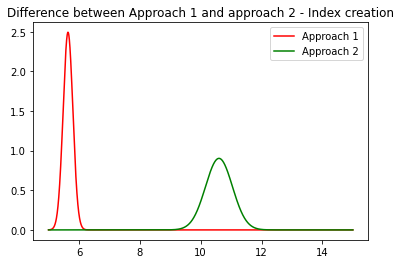

In [58]:
x = np.arange(5, 15, 0.001)
plt.plot(x, norm.pdf(x, 5.64, 0.16),color='red', label='Approach 1')
plt.plot(x, norm.pdf(x, 10.6, 0.442),color='green',label='Approach 2')
plt.title('Difference between Approach 1 and approach 2 - Index creation')
plt.legend()
plt.show()

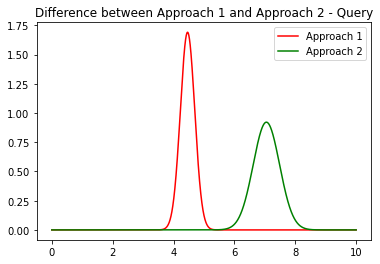

In [59]:
x = np.arange(0, 10, 0.001)
plt.plot(x, norm.pdf(x, 4.46, 0.236),color='red',label='Approach 1')
plt.plot(x, norm.pdf(x, 7.05, 0.433),color='green',label='Approach 2')
plt.title('Difference between Approach 1 and Approach 2 - Query')
plt.legend()
plt.show()

### </ Diversion > :)